In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.optimize import curve_fit
import pystan
import arviz
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## やること
1. 一番使用率（回数）が多いstationを検出する
2. 上位10件くらいをピックアップ
3. それだけで一旦サブセットを作る
4. 外部のデータを使って、それらのstationのavaiable bike/ active dock/ 割合を調べる

In [9]:
df = pd.read_csv("./data/wholetime.csv")
df = df.dropna()

In [10]:
# dfから、station_nameの頻度順に10件取得
station_name = df["start_station_name"].value_counts().index[:10]

# 上位10件のstart_station_nameと頻度を取得
df_top10 = df[df["start_station_name"].isin(station_name)]
df_top10.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
6,41.8957,-87.6201,635.0,Fairbanks St & Superior St,2020-04-02 14:52:32,member,A2759CB06A81F2BC,docked_bike,41.8923,-87.6120,35,Streeter Dr & Grand Ave,2020-04-02 14:47:19,0.771020,"(41.8923, -87.612)","(41.8957, -87.6201)"
64,41.9402,-87.6530,117.0,Wilton Ave & Belmont Ave,2020-04-09 07:03:41,member,AC1964B7D779B523,docked_bike,41.9183,-87.6363,94,Clark St & Armitage Ave,2020-04-09 06:50:48,2.799204,"(41.9183, -87.6363)","(41.9402, -87.653)"
73,41.9295,-87.6431,340.0,Clark St & Wrightwood Ave,2020-04-19 13:55:55,casual,43B958C7162C60B5,docked_bike,41.9030,-87.6313,176,Clark St & Elm St,2020-04-19 13:38:09,3.101916,"(41.903, -87.6313)","(41.9295, -87.6431)"
82,41.8822,-87.6411,77.0,Clinton St & Madison St,2020-04-09 18:17:41,casual,D91E3DCA04F7C5F5,docked_bike,41.9030,-87.6313,176,Clark St & Elm St,2020-04-09 18:02:22,2.449256,"(41.903, -87.6313)","(41.8822, -87.6411)"
89,41.8960,-87.6677,350.0,Ashland Ave & Chicago Ave,2020-04-18 19:21:26,member,FA8235D094269D9D,docked_bike,41.9121,-87.6347,289,Wells St & Concord Ln,2020-04-18 19:03:07,3.270391,"(41.9121, -87.6347)","(41.896, -87.6677)"


In [11]:
# df_top10から、start_station_nameとその頻度を出力
df_top10["start_station_name"].value_counts()

start_station_name
Streeter Dr & Grand Ave     236859
Michigan Ave & Oak St       130527
Clark St & Elm St           127218
Wells St & Concord Ln       123129
Theater on the Lake         120197
Millennium Park             119097
Wells St & Elm St           107285
Kingsbury St & Kinzie St    106370
Clark St & Armitage Ave      99882
Broadway & Barry Ave         97849
Name: count, dtype: int64

In [12]:
# Get the node_list, edge_list and timestamp
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [13]:
top10_node_list, top10_edge_list, top10_timestamp = return_nm(df_top10)

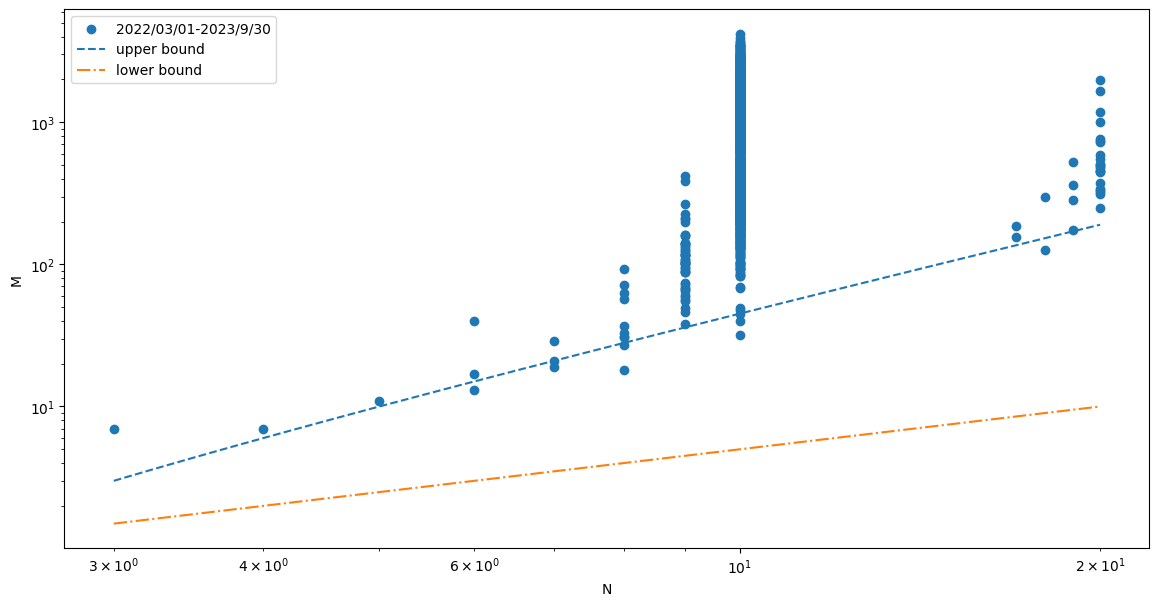

In [14]:
# 駅毎の平均距離を計算
def get_mean_distance(df):
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    mean_distance_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]
        mean_distance_list.append(df_tmp['distance'].mean())
        current_timestamp = next_timestamp

    mean_distance_list = np.array(mean_distance_list)
    timestamp = np.array(timestamp)
    mean_distance_list = mean_distance_list[:len(timestamp)]
    
    return mean_distance_list, timestamp